In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

#### Data Understanding

In [117]:
df = pd.read_csv(r'./data/stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [119]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.nunique())

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64
0
gender                          2
race_ethnicity                  5
parental_level_of_education     6
lunch                           2
test_preparation_course         2
math_score                     81
reading_score                  72
writing_score                  77
dtype: int64


In [120]:
# ValueCount
category_cols = df.select_dtypes(include=["object"]).columns

for col in category_cols:
    print(df[col].value_counts().reset_index(), "\n")

   gender  count
0  female    518
1    male    482 

  race_ethnicity  count
0        group C    319
1        group D    262
2        group B    190
3        group E    140
4        group A     89 

  parental_level_of_education  count
0                some college    226
1          associate's degree    222
2                 high school    196
3            some high school    179
4           bachelor's degree    118
5             master's degree     59 

          lunch  count
0      standard    645
1  free/reduced    355 

  test_preparation_course  count
0                    none    642
1               completed    358 



#### Feature Engineering

In [121]:
df["Total Score"] = df["math_score"] + df["reading_score"] + df["writing_score"]
df["Average"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1).round(2)
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,Total Score,Average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.67
1,female,group C,some college,standard,completed,69,90,88,247,82.33
2,female,group B,master's degree,standard,none,90,95,93,278,92.67
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.33
4,male,group C,some college,standard,none,76,78,75,229,76.33


In [122]:
scores = ["math_score", "reading_score", "writing_score"]
for col in scores:
    print(f"Number of Students with Full mark in {col} is:", len(df[df[col] == 100]))
for col in scores:
    print(f"Number of Students with less than 20 marks in {col} is:", len(df[df[col] <= 20]))

Number of Students with Full mark in math_score is: 7
Number of Students with Full mark in reading_score is: 17
Number of Students with Full mark in writing_score is: 14
Number of Students with less than 20 marks in math_score is: 4
Number of Students with less than 20 marks in reading_score is: 1
Number of Students with less than 20 marks in writing_score is: 3


#### EDA

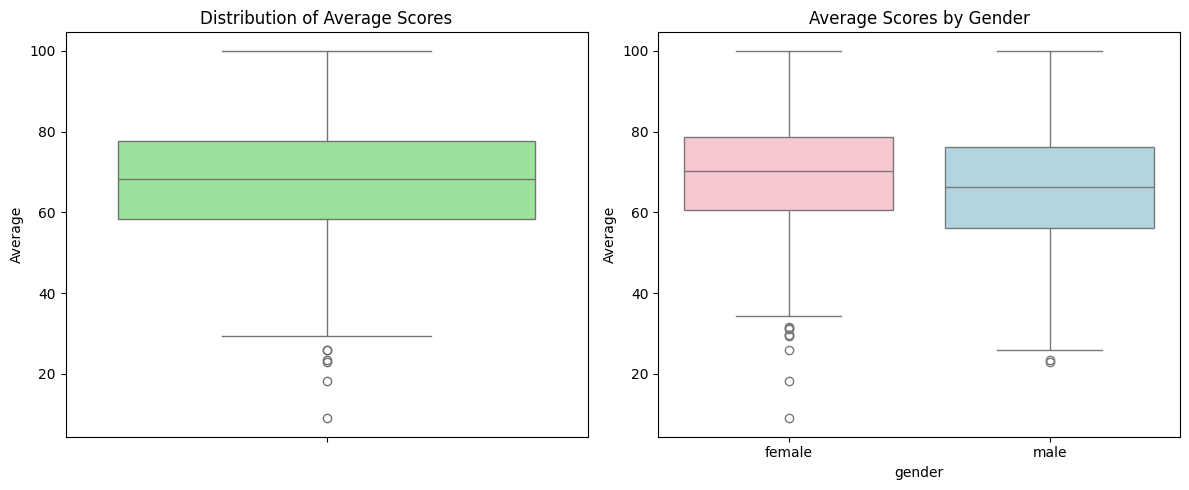

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
warnings.filterwarnings('ignore')

sns.boxplot(data=df, y="Average", color="lightgreen", ax=axs[0])
axs[0].set_title("Distribution of Average Scores")

sns.boxplot(
    data=df,
    x="gender",
    y="Average",
    palette={"female": "pink", "male": "lightblue"},
    ax=axs[1],
)
axs[1].set_title("Average Scores by Gender")

plt.tight_layout()
plt.show()

#####  Insights
- Female students tend to perform well then male students.

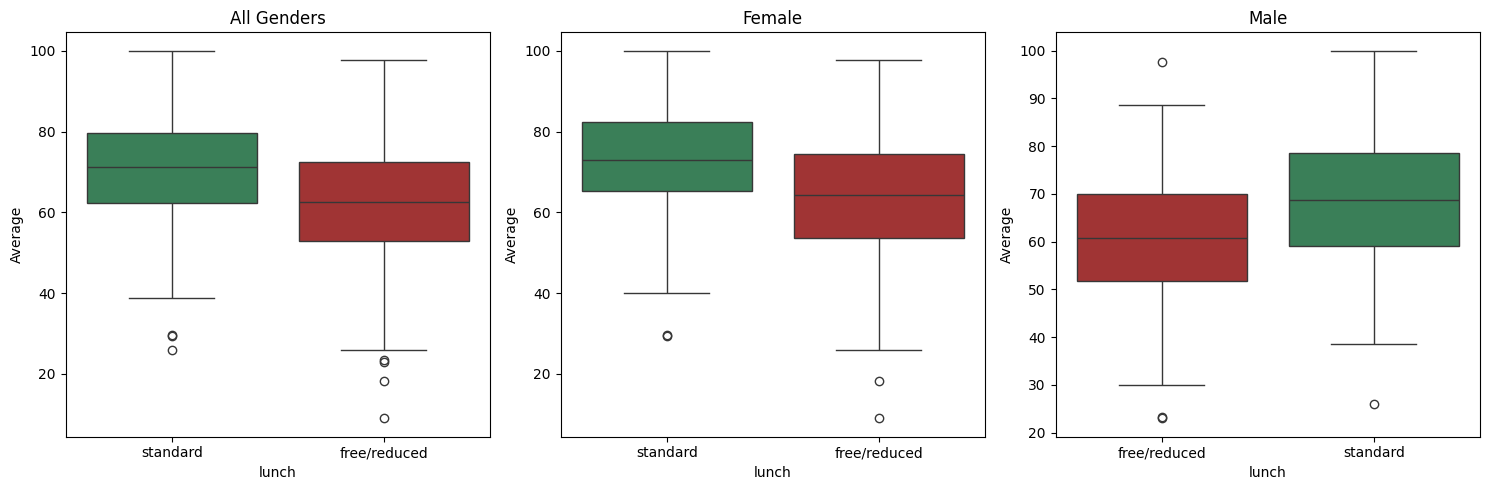

In [124]:
palette_lunch = {"standard": "#2e8b57", "free/reduced": "#b22222"}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
warnings.filterwarnings('ignore')

sns.boxplot(data=df, y='Average', x='lunch', palette=palette_lunch, ax=axes[0])
axes[0].set_title("All Genders")

sns.boxplot(data=df[df.gender == 'female'], y='Average', x='lunch', palette=palette_lunch, ax=axes[1])
axes[1].set_title("Female")

sns.boxplot(data=df[df.gender == 'male'], y='Average', x='lunch', palette=palette_lunch, ax=axes[2])
axes[2].set_title("Male")

plt.tight_layout()
plt.show()


#####  Insights
- Standard lunch helps perform well in exams for all genders.

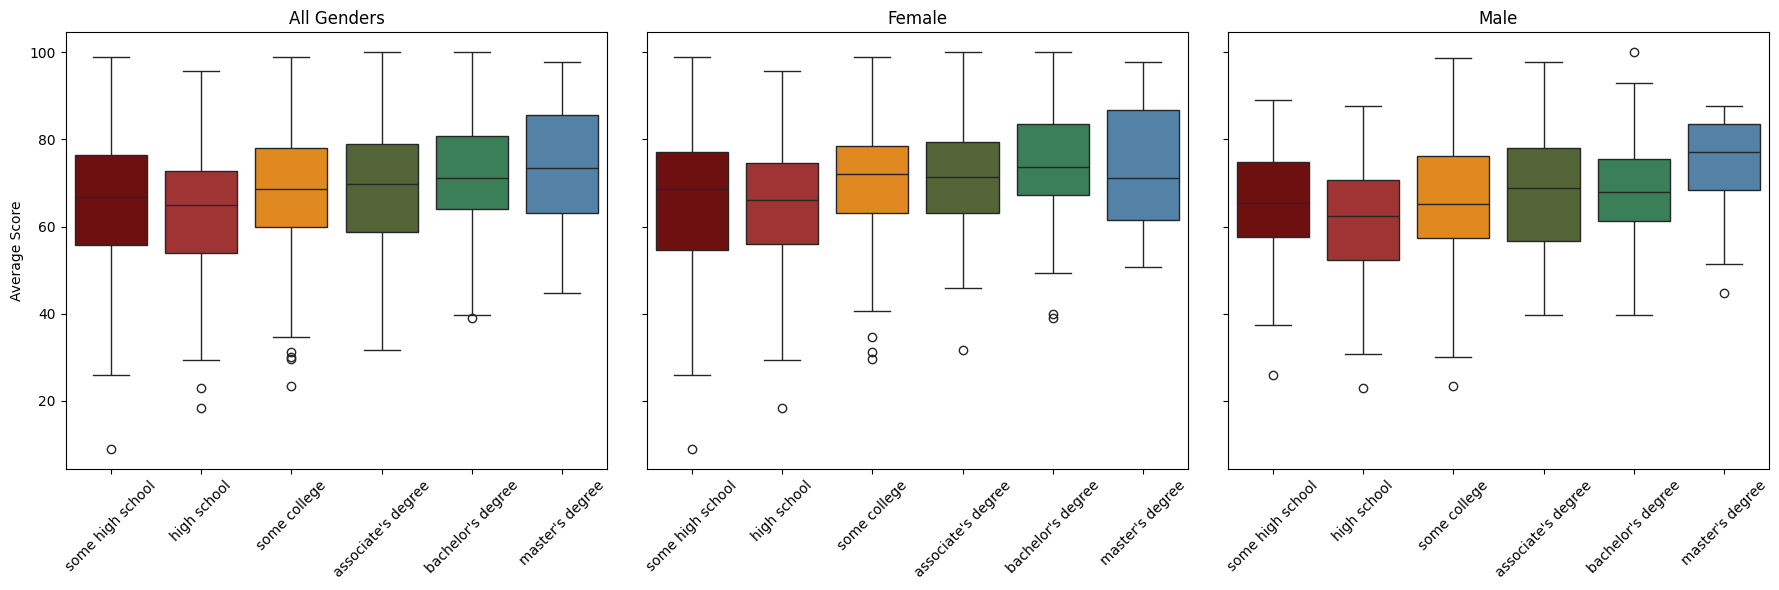

In [125]:
palette_education = {
    "some high school": "#7f0000",      # قرمز تیره
    "high school": "#b22222",            # قرمز آجرین
    "some college": "#ff8c00",           # نارنجی تیره
    "associate's degree": "#556b2f",     # سبز زیتونی
    "bachelor's degree": "#2e8b57",      # سبز متوسط
    "master's degree": "#4682b4"         # آبی فولادی
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

warnings.filterwarnings('ignore')

sns.boxplot(
    data=df,
    x="parental_level_of_education",
    y="Average",
    palette=palette_education,
    ax=axes[0],
    order=palette_education.keys()
)
axes[0].set_title("All Genders")
axes[0].set_xlabel("")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(
    data=df[df.gender == "female"],
    x="parental_level_of_education",
    y="Average",
    palette=palette_education,
    ax=axes[1],
    order=palette_education.keys()
)
axes[1].set_title("Female")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(
    data=df[df.gender == "male"],
    x="parental_level_of_education",
    y="Average",
    palette=palette_education,
    ax=axes[2],
    order=palette_education.keys()
)
axes[2].set_title("Male")
axes[2].set_xlabel("")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Insight
- Students whose parents have a "master's degree" or "bachelor's degree" tend to have better scores.

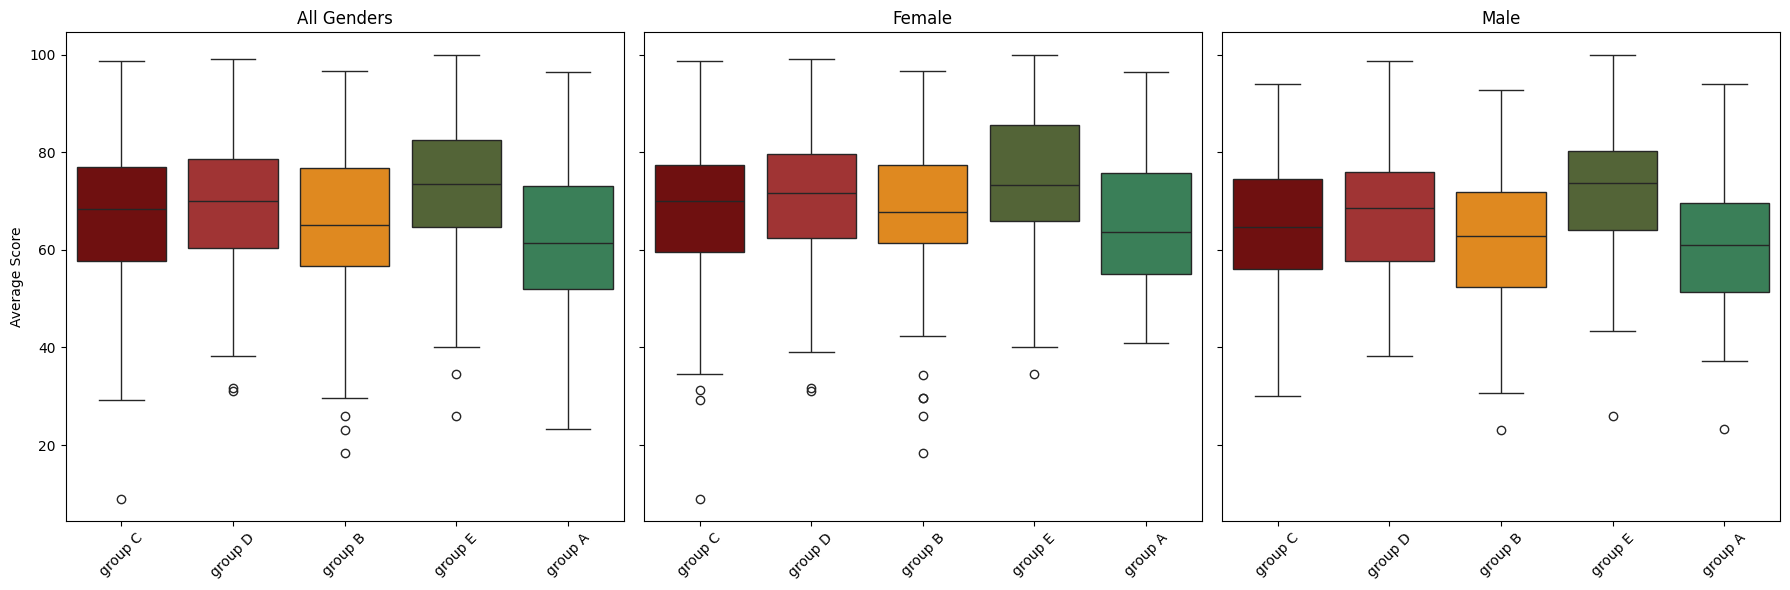

In [126]:
palette_race = {
    "group C": "#7f0000",  # قرمز تیره
    "group D": "#b22222",  # قرمز آجرین
    "group B": "#ff8c00",  # نارنجی تیره
    "group E": "#556b2f",  # سبز زیتونی
    "group A": "#2e8b57",  # سبز متوسط
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

warnings.filterwarnings("ignore")

sns.boxplot(
    data=df,
    x="race_ethnicity",
    y="Average",
    palette=palette_race,
    ax=axes[0],
    order=palette_race.keys(),
)
axes[0].set_title("All Genders")
axes[0].set_xlabel("")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(
    data=df[df.gender == "female"],
    x="race_ethnicity",
    y="Average",
    palette=palette_race,
    ax=axes[1],
    order=palette_race.keys(),
)
axes[1].set_title("Female")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=45)

sns.boxplot(
    data=df[df.gender == "male"],
    x="race_ethnicity",
    y="Average",
    palette=palette_race,
    ax=axes[2],
    order=palette_race.keys(),
)
axes[2].set_title("Male")
axes[2].set_xlabel("")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

#### Insights
- Students of group A and gruop B tends to perform poorly in Exams.
- Students of group E and gruop D tends to perform Better in Exams.

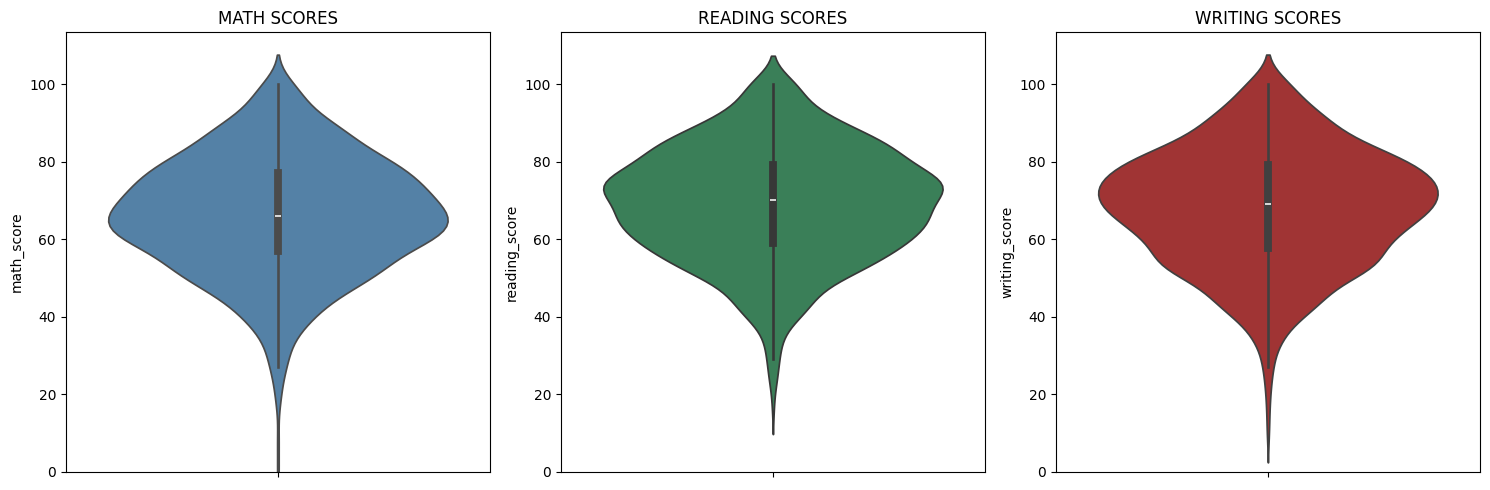

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.violinplot(data=df, y="math_score", color="#4682b4", ax=axes[0])
axes[0].set_title("MATH SCORES")

sns.violinplot(data=df, y="reading_score", color="#2e8b57", ax=axes[1])
axes[1].set_title("READING SCORES")

sns.violinplot(data=df, y="writing_score", color="#b22222", ax=axes[2])
axes[2].set_title("WRITING SCORES")

max_y = max(
    axes[0].get_ylim()[1],
    axes[1].get_ylim()[1],
    axes[2].get_ylim()[1],
)

for ax in axes:
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()

#### Insights
- From the above three plots its clearly visible that most of the students score in between 55-75 in Maths whereas in reading and writing most of them score from 60-80

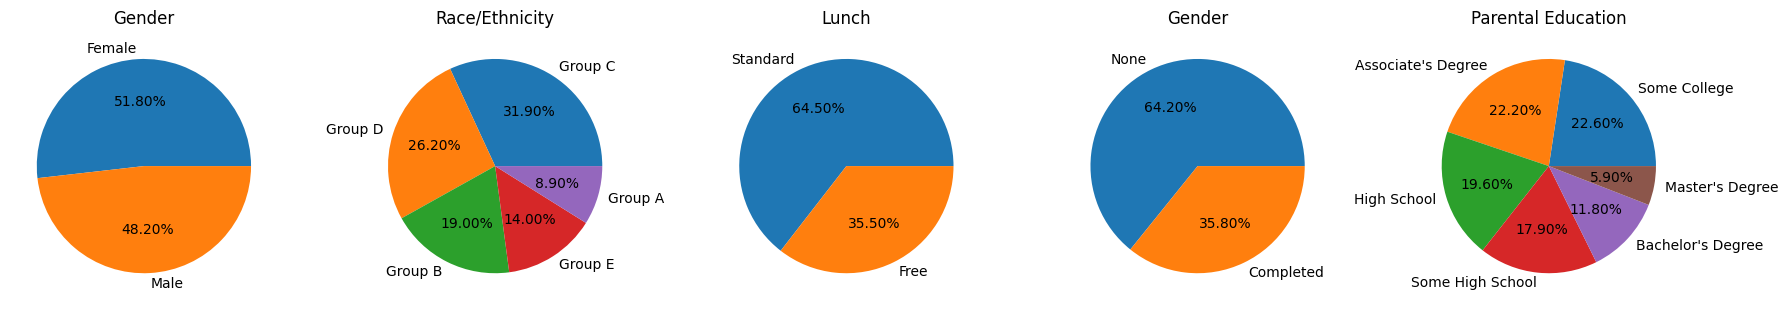

In [128]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

axes[0].pie(x=df["gender"].value_counts(), labels=["Female", "Male"], autopct="%.2f%%")
axes[0].set_title("Gender")

axes[1].pie(
    x=df["race_ethnicity"].value_counts(),
    labels=["Group C", "Group D", "Group B", "Group E", "Group A"],
    autopct="%.2f%%",
)
axes[1].set_title("Race/Ethnicity")

axes[2].pie(x=df["lunch"].value_counts(), labels=["Standard", "Free"], autopct="%.2f%%")
axes[2].set_title("Lunch")

axes[3].pie(
    x=df["test_preparation_course"].value_counts(),
    labels=["None", "Completed"],
    autopct="%.2f%%",
)
axes[3].set_title("Gender")

axes[4].pie(
    x=df["parental_level_of_education"].value_counts(),
    labels=[
        "Some College",
        "Associate's Degree",
        "High School",
        "Some High School",
        "Bachelor's Degree",
        "Master's Degree",
    ],
    autopct="%.2f%%",
)
axes[4].set_title("Parental Education")

plt.tight_layout()
plt.show()

#####  Insights
- Number of Male and Female students is almost equal
- Number students are greatest in Group C
- Number of students who have standard lunch are greater
- Number of students who have not enrolled in any test preparation course is greater
- Number of students whose parental education is "Some College" is greater followed closely by "Associate's Degree"

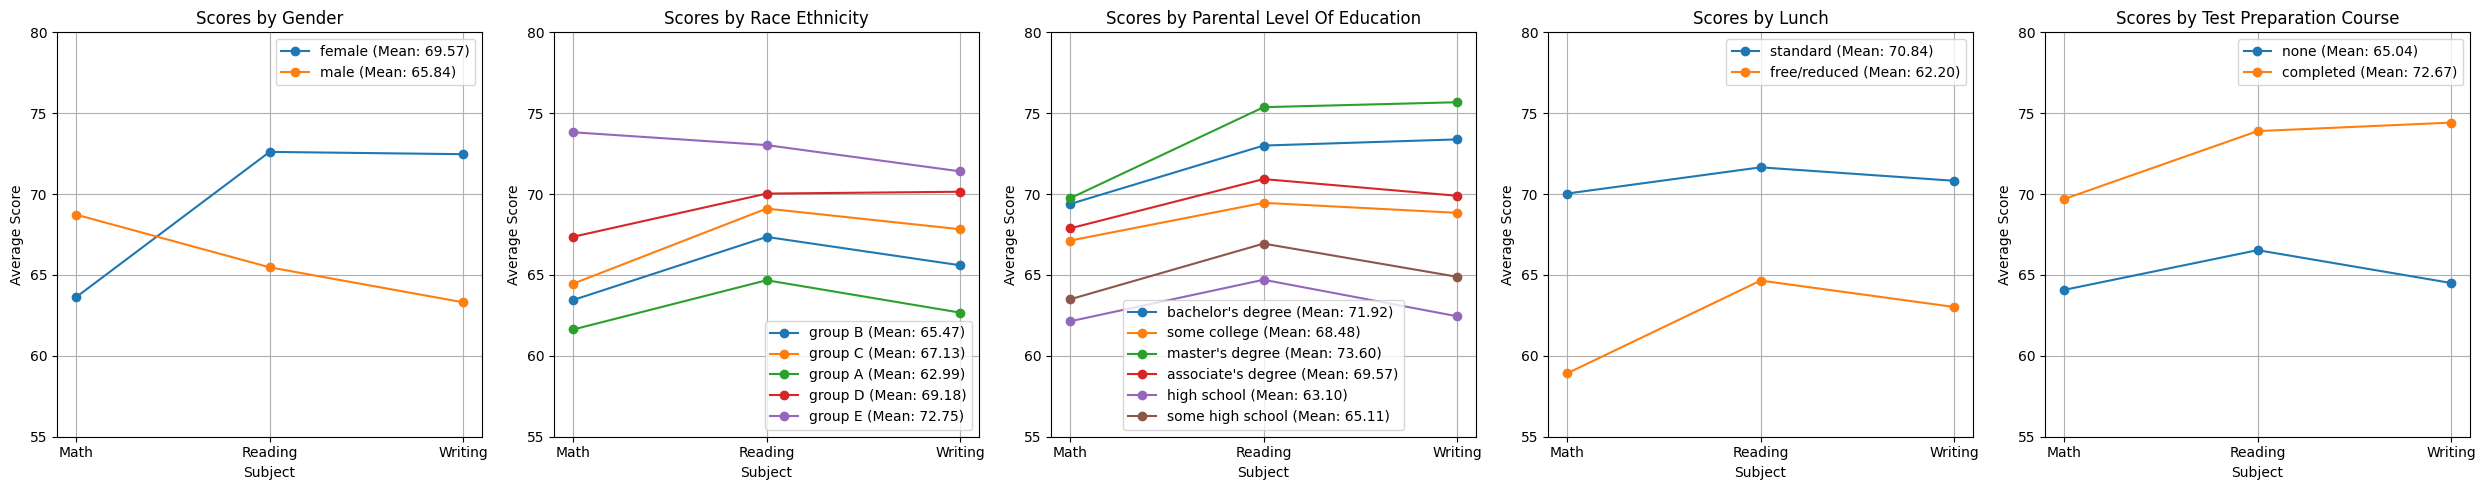

In [129]:
scores = ["math_score", "reading_score", "writing_score"]
x = np.arange(len(scores))

group_columns = [
    "gender",
    "race_ethnicity",
    "parental_level_of_education",
    "lunch",
    "test_preparation_course"
]

fig, axs = plt.subplots( 1,len(group_columns), figsize=(25,5))

for i, col in enumerate(group_columns):
    grouped = df.groupby(col)[scores].mean()
    groups = df[col].unique()
    group_scores = {}
    group_scores_mean = {}

    for group in groups:
        group_scores[group] = grouped.loc[group, scores]
        group_scores_mean[group] = group_scores[group].mean()
        y = group_scores[group]
        axs[i].plot(x, y, marker="o", label=f"{group} (Mean: {group_scores_mean[group]:.2f})")

    axs[i].set_ylim(55, 80)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(["Math", "Reading", "Writing"])
    axs[i].set_xlabel("Subject")
    axs[i].set_ylabel("Average Score")
    axs[i].set_title(f"Scores by {col.replace('_', ' ').title()}")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


#### Insights 
- On an average females have a better overall score than men.
- whereas males have scored higher in Maths.
- Group E students have scored the highest marks. 
- Group A students have scored the lowest marks. 
- Students from a lower Socioeconomic status have a lower avg in all course subjects
- The score of student whose parents possess master and bachelor level education are higher than others.
- Students who get Standard Lunch tend to perform better than students who got free/reduced lunch

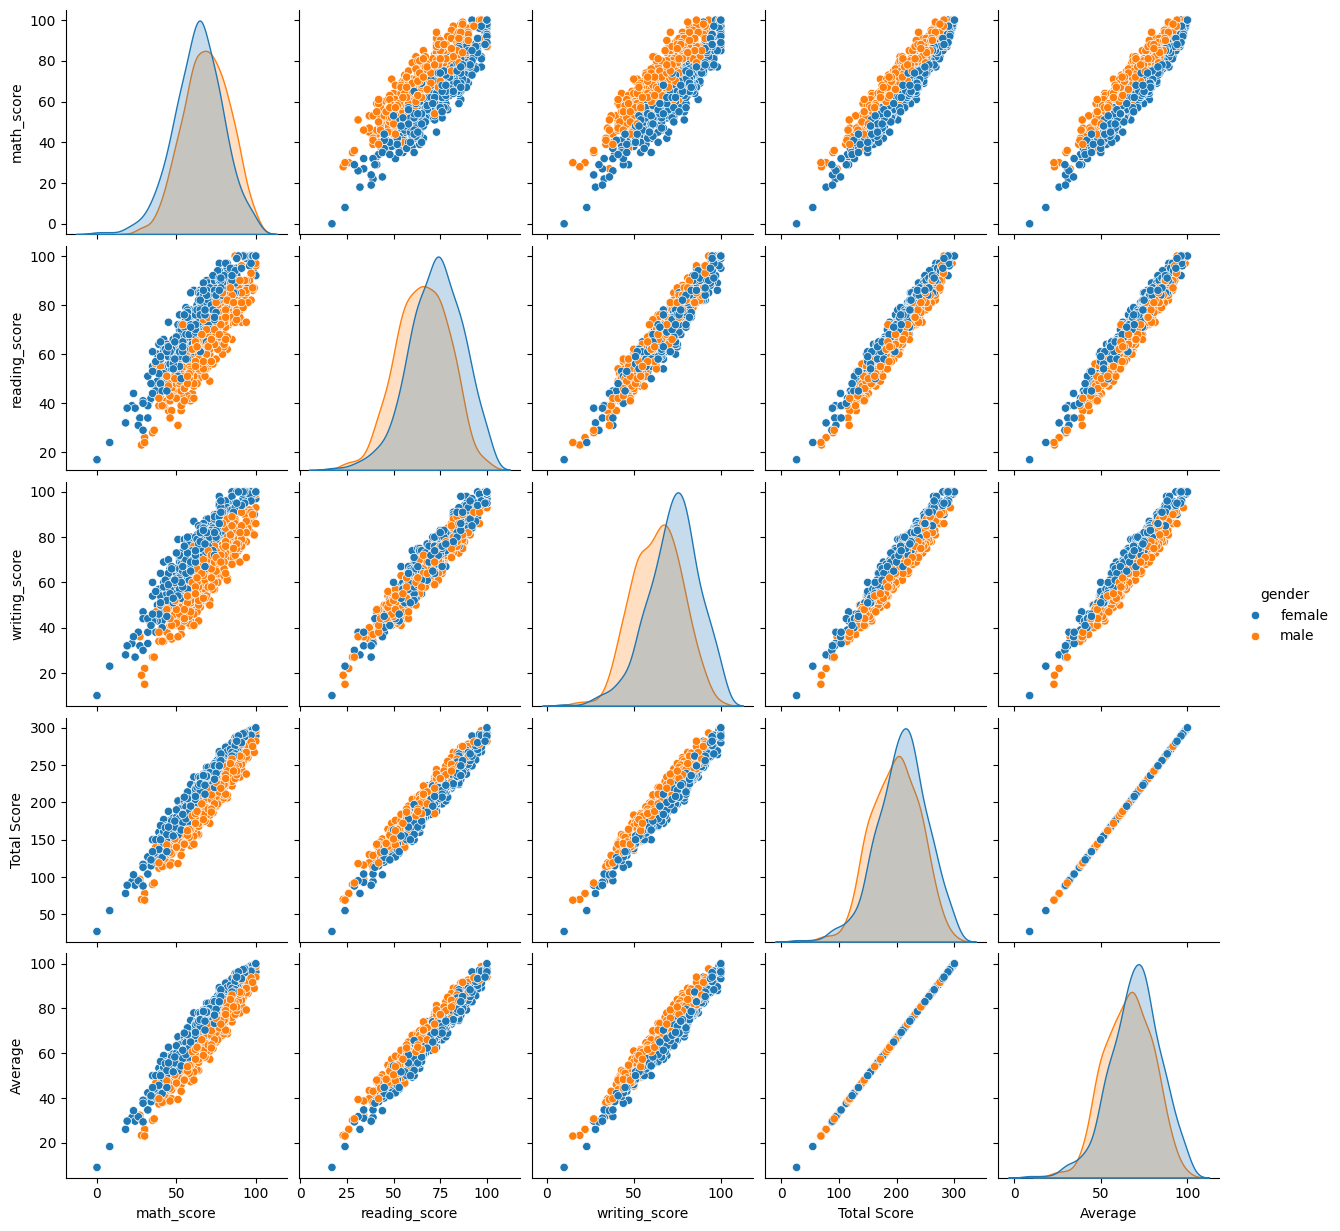

In [130]:
sns.pairplot(df, hue="gender")

Text(0.5, 1.0, 'Correlation Heatmap')

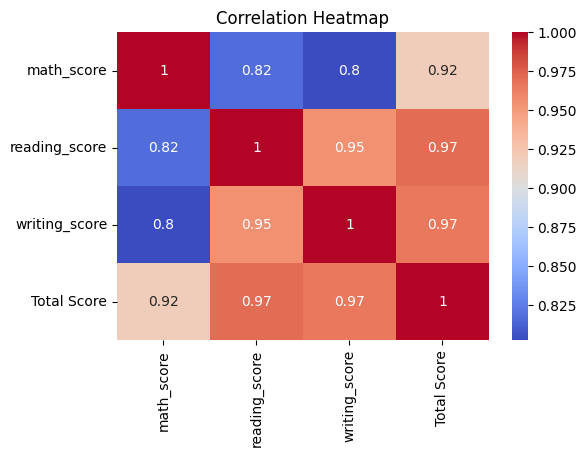

In [131]:
plt.figure(figsize=(6,4))
sns.heatmap(df.select_dtypes(include='int').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")

### Modeling

##### Feature Engineering

In [132]:
# Preparing X and Y variables
X = df.drop(columns=["math_score"], axis=1)
y = df["math_score"]

numerical_features = X.select_dtypes(exclude="object").columns
category_features = X.select_dtypes(include="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", OneHotEncoder(drop="first"), category_features),
        ("StandardScaler", StandardScaler(), numerical_features),
    ],
    remainder="passthrough",
)

X = preprocessor.fit_transform(X)
print(X.shape)

(1000, 16)


In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [147]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_jobs=1),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
}


def RegressionModelsFitter(models, give=False):
    Fitted_models = {}
    Results = {}
    keys = list(models.keys())
    for i in range(len(keys)):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Performance Metrics For Training Set
        model_train_r2 = r2_score(y_train, y_train_pred)

        # Performance Metrics For Test Set
        model_test_r2 = r2_score(y_test, y_test_pred)

        # Printing The Results
        print(keys[i])
        print("Model performance for Training set")
        print("- R2 Score: {:.4f}".format(model_train_r2))
        print("-" * 35)
        print("Model performance for Test set")
        print("- R2 Score: {:.4f}".format(model_test_r2))
        print("=" * 35, "\n")

        if give:
            Fitted_models[keys[i]] = model
            Results[keys[i]] = {
                "Model_name": keys[i],
                "train_r2": model_train_r2,
                "test_r2": model_test_r2,
                "y_test_pred": y_test_pred,
            }

    if give:
        return Fitted_models, Results


Fitted_models, Results = RegressionModelsFitter(models, True)

Linear Regression
Model performance for Training set
- R2 Score: 1.0000
-----------------------------------
Model performance for Test set
- R2 Score: 1.0000

Lasso
Model performance for Training set
- R2 Score: 0.9004
-----------------------------------
Model performance for Test set
- R2 Score: 0.9086

Ridge
Model performance for Training set
- R2 Score: 0.9995
-----------------------------------
Model performance for Test set
- R2 Score: 0.9995

K-Neighbors Regressor
Model performance for Training set
- R2 Score: 0.9175
-----------------------------------
Model performance for Test set
- R2 Score: 0.8907

Decision Tree
Model performance for Training set
- R2 Score: 1.0000
-----------------------------------
Model performance for Test set
- R2 Score: 0.9457

Random Forest Regressor
Model performance for Training set
- R2 Score: 0.9949
-----------------------------------
Model performance for Test set
- R2 Score: 0.9649

XGBRegressor
Model performance for Training set
- R2 Score: 0.99

In [160]:
df_results = pd.DataFrame(
    {
        "Model Name": list(models.keys()),
        "R2_Score_test": [Results[model]["test_r2"] for model in list(models.keys())],
        "R2_Score_train": [Results[model]["train_r2"] for model in list(models.keys())],
    }
).sort_values(by="R2_Score_test", ascending=False)
df_results

,Model Name,R2_Score_test,R2_Score_train
0,Linear Regression,1.000000,1.000000
2,Ridge,0.999517,0.999493
6,XGBRegressor,0.976718,0.999914
7,CatBoosting Regressor,0.971004,0.996229
5,Random Forest Regressor,0.964915,0.994914
4,Decision Tree,0.945672,1.000000
8,AdaBoost Regressor,0.925188,0.929598
1,Lasso,0.908561,0.900424
3,K-Neighbors Regressor,0.890744,0.917548


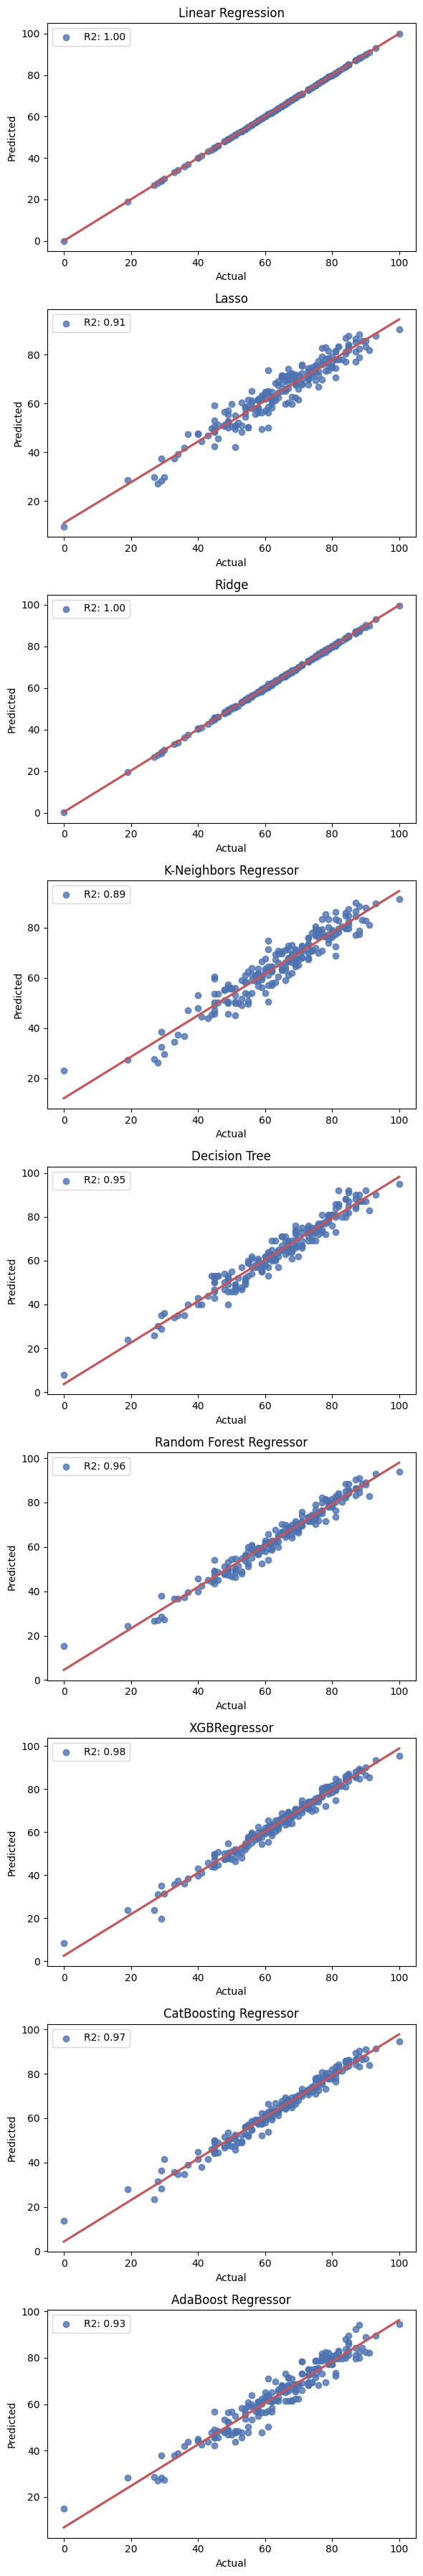

In [162]:
model_names = list(models.keys())

fig, axes = plt.subplots(len(model_names), 1, figsize=(6, 4 * len(model_names)))

for i, model_name in enumerate(model_names):
    axes[i].set_title(model_name)
    sns.regplot(
        x=y_test,
        y=Results[model_name]["y_test_pred"],
        ci=None,
        color="#C65458",
        scatter_kws={"color": "#4C72B0"},
        ax=axes[i],
        label=f"R2: {Results[model_name]['test_r2']:.2f}",
    )
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")
    axes[i].legend()
plt.tight_layout()
plt.show()